# Deep Convolutional GAN (DCGAN) with NPY files

In [1]:
# GPU使用時の設定
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

## 環境変数を設定

In [2]:
# 引き継ぐ学習回数の指定
train_iterates = 0
# 画像サイズの設定
image_size = 64

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, array_to_img
#モデルの可視化
from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils.vis_utils import plot_model
from keras.models import load_model	
import glob

Using TensorFlow backend.
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [4]:
# 入力画像サイズを変更できる様にする
img_rows = 256
img_cols = 256
channels = 3

# 入力画像の形状（64 x 64 x 3) //カラー画像
img_shape = (img_rows, img_cols, channels)

# noiseベクトルサイズ（生成器へのINPUT)
z_dim = 100

## Generator

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # 全結合層によってnoiseベクトル(200次元）をReshapeして7x7x256 tensorに変換する
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))

    # 転置畳み込みにより8x8x256 から 16x16x128テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより16x16x128 から 32x32x64テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより32x32x64 から32x32x32 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    # 転置畳み込みにより32x32x32 から64x64x64 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 32x32x32 to 64x64x3 tensor
    #入力画像サイズを変更できる様にする 64*strides→出力サイズ
    model.add(Conv2DTranspose(3, kernel_size=3, strides=4, padding='same'))

    # tanh活性化を適用して出力（最終層だけはバッチ正規化はしない）
    model.add(Activation('tanh'))

    return model

Instructions for updating:
Colocations handled automatically by placer.


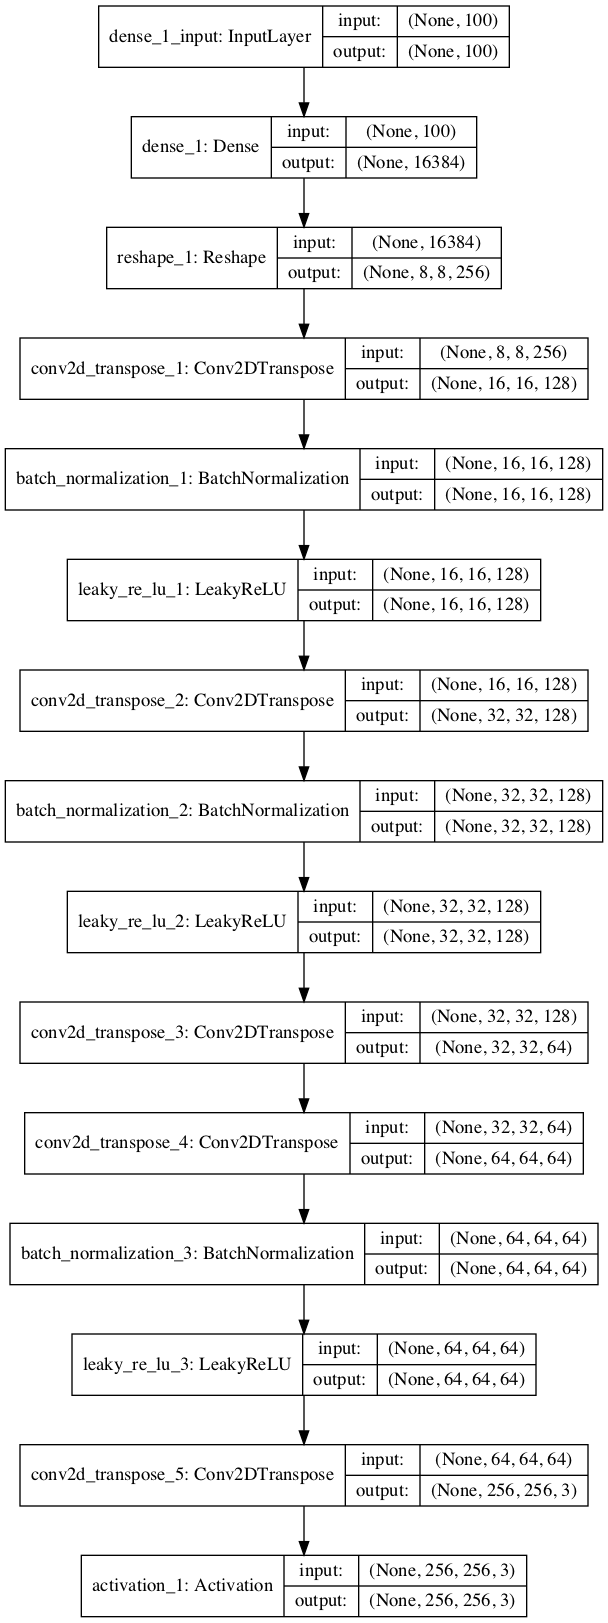

In [6]:
build_model = build_generator(z_dim)

plot_model(build_model, to_file="DCGAB_build_model.png", show_shapes=True)

## Discriminator

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    # 64x64x3(入力画像) を32x32x32のテンソルにする畳み込み層
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same')) #padding=sameにすると、入力の大きさをstridesの大きさで単純に割ったもの(28/2=14)が出力の大きさになる

    # Leaky ReLUによる活性化(最初の層にはバッチ正規化は適用しない)
    model.add(LeakyReLU(alpha=0.01))

    # 32x32x32 を16x16x64のテンソルにする畳み込み層
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))

    # 16x16x64 を8x8x128のテンソルにする畳み込み層
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # シグモイド関数で出力（０～１）
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

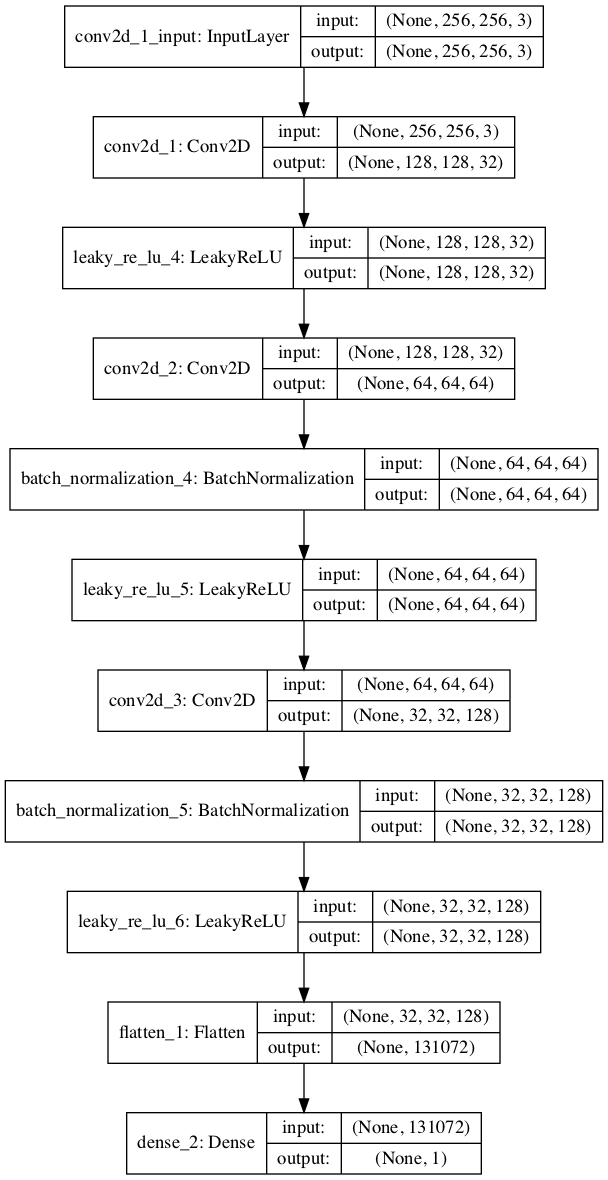

In [8]:
discriminator_model = build_discriminator(img_shape)

plot_model(discriminator_model, to_file="DCGAB_discriminator_model.png", show_shapes=True)

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別機を結合
    model.add(generator)
    model.add(discriminator)

    return model

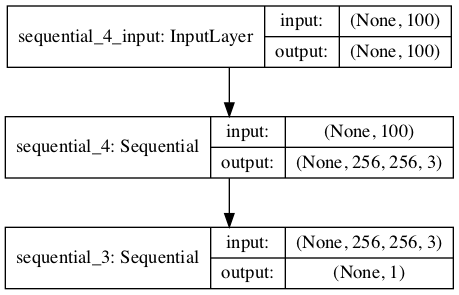

In [10]:
discriminator = build_discriminator(img_shape)
generator = build_generator(z_dim)
gan_model = build_gan(generator, discriminator)

plot_model(gan_model, to_file="DCGAB_gan_model.png", show_shapes=True)

In [11]:
# 識別機の生成とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#前回学習の重みをロード
if train_iterates > 0:
    weights_path_1 = 'dcgan/models/D/d_model-' + str(train_iterates) + '.h5'
    discriminator.load_weights(weights_path_1)

# 生成器の生成
generator = build_generator(z_dim)

# 生成器の訓練時は識別機のパラメータを固定する
discriminator.trainable = False

# 識別機は固定のまま生成器を訓練するGANモデルの生成とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
#途中までの学習済みモデルのロード
from keras.models import load_model

model_g_dir = "dcgan/models/G"
model_d_dir = "dcgan/models/D"
if train_iterates > 0:
    models_path_1 = model_g_dir + '/g_param-' + str(train_iterates) + '.hdf5'
    generator.load_weights(models_path_1)

if train_iterates > 0:
    models_path_2 = model_g_dir + '/gan_param-' + str(train_iterates) + '.hdf5'
    gan.load_weights(models_path_2)

## Training

In [13]:
losses = []
accuracies = []
iteration_checkpoints = []
output_dir = "dcgan/data/result"
model_g_dir = "dcgan/models/G"
model_d_dir = "dcgan/models/D"
num_of_trials = train_iterates

def train(iterations, batch_size, sample_interval):
  # 学習するデータセットを読み込む
  datasets = np.load("/Users/murakamikei/Desktop/GanPractice/dcgan/data/result.npy")

  # ndary型に変換
  X_train = datasets # (2000, 64, 64, 3)

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
    
  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))
  print("check-001")

  for iteration in range(iterations):

      # -------------------------
      #  Train the Discriminator
      # -------------------------
      print("iteration=", iteration)
      # Get a random batch of real images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
       # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)
       # Train Discriminator
      d_loss_real = discriminator.train_on_batch(imgs, real)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
     
      
      # ---------------------
      #  Train the Generator
      # ---------------------

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)

      # Train Generator
      g_loss = gan.train_on_batch(z, real)

      # if (iteration + 1) % sample_interval == 0:
      if iteration % sample_interval == 0:
          # Save losses and accuracies so they can be plotted after training
          losses.append((d_loss, g_loss))
          accuracies.append(100.0 * accuracy)
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

          # Output a sample of generated image
          sample_images(generator, iteration)
          #識別器のモデル保存
          d_model_file=os.path.join(model_d_dir, "d_model-" + str(iteration + num_of_trials) +  ".h5")
          d_param_file=os.path.join(model_d_dir, "d_param-" + str(iteration + num_of_trials) +  ".hdf5")
          discriminator.save(d_model_file)	
          discriminator.save_weights(d_param_file)
          
          #生成器のモデル保存
          g_model_file=os.path.join(model_g_dir, "g_model-" + str(iteration + num_of_trials) +  ".h5")
          g_param_file=os.path.join(model_g_dir, "g_param-" + str(iteration + num_of_trials) +  ".hdf5")
          generator.save(g_model_file)	
          generator.save_weights(g_param_file)
          gan_model_file=os.path.join(model_g_dir, "gan_model-" + str(iteration + num_of_trials) +  ".h5")
          gan_param_file=os.path.join(model_g_dir, "gan_param-" + str(iteration + num_of_trials) +  ".hdf5")

          gan.save(gan_model_file)	
          gan.save_weights(gan_param_file)
          
          



In [14]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)  # (16, 64, 64, 3)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    print("生成されている画像の枚数とサイズ", gen_imgs.shape)
    # print("gen_imgs_type=", type(gen_imgs.shape))
    print("生成されている一枚一枚の画像サイズ=", gen_imgs[0,:,:,:].shape)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            print("shape=",gen_imgs[cnt, :, :, :].shape)
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    #file保存
    output_file = os.path.join(output_dir, 'result_' + str(iteration + num_of_trials) +'.png')
    plt.savefig(output_file)


In [ ]:
# Set hyperparameters

batch_size = 64

iterations =  100
sample_interval = 10

if train_iterates > 0:
    iterations = 20000
    sample_interval = 100


# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

check-001
iteration= 0
Instructions for updating:
Use tf.cast instead.


/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
